In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
from cellpose.io import imread
import glob
from pathlib import Path
from PIL import Image, ImageSequence
from tqdm import tqdm
import os
import os.path
from livecell_tracker import segment
from livecell_tracker import core
from livecell_tracker.core import datasets
from livecell_tracker.core.datasets import LiveCellImageDataset
from skimage import measure
from livecell_tracker.core import SingleCellTrajectory, SingleCellStatic
import detectron2
from detectron2.utils.logger import setup_logger

setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from livecell_tracker.segment.detectron_utils import gen_cfg

from livecell_tracker.segment.detectron_utils import (
    segment_detectron_wrapper,
    segment_images_by_detectron,
    convert_detectron_instance_pred_masks_to_binary_masks,
    convert_detectron_instances_to_label_masks,
)
from livecell_tracker.segment.detectron_utils import (
    convert_detectron_instance_pred_masks_to_binary_masks,
    convert_detectron_instances_to_label_masks,
    segment_images_by_detectron,
    segment_single_img_by_detectron_wrapper,
)

pretrained_model_path = (
    r"./notebook_results/train_log/detectron_train_output__ver0.0.2/model_final.pth"
)
# seg_out_dir = Path(r"""./notebook_results/train_log/detectron_train_output__ver0.0.2/""")
model_dir = Path(r"""./notebook_results/train_log/detectron_train_output__ver0.0.2/""")
out_dir = Path(r"./notebook_results/wayne_data/")
seg_out_dir = out_dir / "segmentation"
track_out_dir = out_dir / "tracking"
segmentation_result_json_path = seg_out_dir / "segmentation_results.json"
trajectory_collection_path = track_out_dir / "trajectory_collection.json"
assert os.path.exists(model_dir)
os.makedirs(seg_out_dir, exist_ok=True)
os.makedirs(track_out_dir, exist_ok=True)
pretrained_model_path = (
    r"./notebook_results/train_log/detectron_train_output__ver0.0.2/model_final.pth"
)


In [2]:
from pathlib import Path
import glob
dataset_dir_path = Path("../datasets/wayne/single_tiff")
ext = "tif"
img_path_list = sorted(glob.glob(str((Path(dataset_dir_path) / Path("*.%s" % (ext))))))

In [3]:
filenames = [os.path.basename(path) for path in img_path_list]

In [4]:
filenames[0]

'0028_frame_0.tif'

In [5]:
cell_data = [name.replace(".", "_").split("_") for name in filenames]
cell_ids = [data[0] for data in cell_data]
timeframes = [int(data[2]) for data in cell_data]

cell_id_and_timeframes = list(zip(cell_ids, timeframes))

In [6]:
import functools
def cmp_cells(x1, x2):
    if x1[0] < x2[0]:
        return -1
    elif x1[0] > x2[0]:
        return 1
    else:
        return -1 if x1[1] < x2[1] else 1

cell_id_to_timeframes = {}
for cell_id, timeframes in cell_id_and_timeframes:
    if cell_id not in cell_id_to_timeframes:
        cell_id_to_timeframes[cell_id] = []
    cell_id_to_timeframes[cell_id].append(timeframes)

sorted_cell_id_and_timeframes = sorted(cell_id_and_timeframes, key=functools.cmp_to_key(cmp_cells))
sorted_cell_id_and_timeframes[:20]

[('0028', 0),
 ('0028', 1),
 ('0028', 2),
 ('0029', 0),
 ('0029', 1),
 ('0029', 2),
 ('0029', 3),
 ('0029', 4),
 ('0029', 5),
 ('0029', 6),
 ('0029', 7),
 ('0029', 8),
 ('0029', 9),
 ('0029', 10),
 ('0029', 11),
 ('0029', 12),
 ('0029', 13),
 ('0029', 14),
 ('0029', 15),
 ('0029', 16)]

In [7]:
def construct_wayne_filename(cell_id, timeframe):
    return "%s_frame_%d.%s" % (cell_id, timeframe, ext)

def construct_wayne_filenames(cell_id, timeframes):
    res = []
    for timeframe in timeframes:
        res.append(construct_wayne_filename(cell_id, timeframe))
    return res

# sorted_filenames = [construct_wayne_filename(cell_id, timeframe) for cell_id, timeframe in sorted_cell_id_and_timeframes]
# sorted_filenames[:20]

## Construct single cell trajectories

In [8]:
from livecell_tracker.core import SingleCellStatic, SingleCellTrajectory, SingleCellTrajectoryCollection
from livecell_tracker.core.datasets import LiveCellImageDataset


single_cell_trajs = []
sc_traj_collection = SingleCellTrajectoryCollection()
for cell_id in cell_id_to_timeframes:
    timeframes = cell_id_to_timeframes[cell_id]
    filenames = construct_wayne_filenames(cell_id, timeframes)
    sorted_paths = [str(Path(dataset_dir_path) / Path(filename)) for filename in filenames]
    img_dataset = LiveCellImageDataset(img_path_list=sorted_paths)

    single_cell_trajectory = SingleCellTrajectory(cell_id, raw_img_dataset=img_dataset)
    for timeframe in timeframes:
        single_cell_static = SingleCellStatic(timeframe, img_dataset=img_dataset)
        single_cell_trajectory.add_single_cell(timeframe, single_cell_static)
    
    single_cell_trajs.append(single_cell_trajectory)
    sc_traj_collection.add_trajectory(single_cell_trajectory)


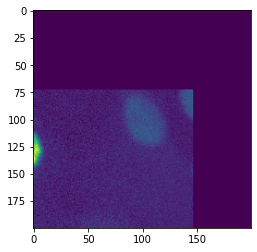

In [9]:
traj = single_cell_trajs[3]
some_sc = traj[0]
some_img = some_sc.get_img()
plt.imshow(some_img)

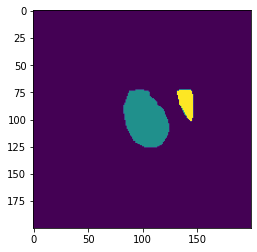

In [10]:
from typing import Tuple, Union
from livecell_tracker.segment.cellpose_utils import segment_single_image_by_cellpose
from livecell_tracker.segment.utils import get_contours_from_pred_masks

cellpose_model = models.Cellpose(gpu=True, model_type="cyto")
def segment_update_sc_by_cellpose(sc: SingleCellStatic) -> Tuple[bool,Union[None, np.array]]:
    """segment and update single cell classes

    Parameters
    ----------
    sc : SingleCellStatic
        _description_

    Returns
    -------
    return 
    """    
    img = sc.get_img()
    pred = segment_single_image_by_cellpose(img, model = cellpose_model, diameter=30)
    w, h = img.shape
    center_val = pred[w//2, h//2]
    reserved_pred = pred.copy()
    reserved_pred[reserved_pred != center_val] = 0
    contours = get_contours_from_pred_masks([reserved_pred])
    if len(contours) == 0:
        fig, axes = plt.subplots(1, 3)
        axes[0].imshow(img)
        axes[1].imshow(pred)
        axes[2].imshow(reserved_pred)
        return False, None
    # check number of contours, one contour's length and contour's coord dimension
    # print(len(contours), len(contours[0]), len(contours[0][0]))
    sc.update_contour(contours[0])
    return True, pred

success, mask = segment_update_sc_by_cellpose(some_sc)
plt.imshow(mask)

In [11]:
from tqdm import tqdm

def segment_update_traj(sc_traj: SingleCellTrajectory):
    sc_ids = list(sc_traj.timeframe_set)
    for sc_id in sc_ids:
        sc = traj[sc_id]
        success, mask = segment_update_sc_by_cellpose(sc)
        if not success:
            traj.pop_single_cell(sc.timeframe)

segment_update_traj(traj)

## Save to disk and reconstruct

In [12]:
traj.write_json(out_dir/"test_traj.json")

In [13]:
import json
with open(out_dir/"test_traj.json", "r") as f:
    data = json.load(f)
    tmp_traj = SingleCellTrajectory().load_from_json_dict(data)
    print(tmp_traj.timeframe_set)
    print(tmp_traj.raw_img_dataset.to_json_dict())
    print(tmp_traj.timeframe_to_single_cell)

{0, 1, 2}
{'name': 'livecell-base', 'data_dir_path': 'None', 'img_path_list': ['../datasets/wayne/single_tiff/0033_frame_0.tif', '../datasets/wayne/single_tiff/0033_frame_1.tif', '../datasets/wayne/single_tiff/0033_frame_2.tif'], 'max_cache_size': 50, 'ext': 'tif'}
{0: <livecell_tracker.core.single_cell.SingleCellStatic object at 0x000001869A8BE5E0>, 1: <livecell_tracker.core.single_cell.SingleCellStatic object at 0x000001869A889DF0>, 2: <livecell_tracker.core.single_cell.SingleCellStatic object at 0x000001869A889AF0>}


In [14]:
from livecell_tracker.trajectory import feature_extractors

traj.compute_features("haralick", feature_extractors.compute_haralick_features)
traj.compute_features("skimage", feature_extractors.compute_skimage_regionprops)
traj.get_sc_feature_table()

,haralick_0,haralick_1,haralick_2,haralick_3,haralick_4,haralick_5,haralick_6,haralick_7,haralick_8,haralick_9,...,skimage_moments_weighted_normalized-2-2,skimage_moments_weighted_normalized-2-3,skimage_moments_weighted_normalized-3-0,skimage_moments_weighted_normalized-3-1,skimage_moments_weighted_normalized-3-2,skimage_moments_weighted_normalized-3-3,skimage_orientation,skimage_perimeter,skimage_perimeter_crofton,skimage_solidity
0,0.004051,19.356393,0.681229,30.390983,0.242941,50.609847,102.207538,5.29416,8.332393,0.002321,...,0.000008,3.754120e-08,-0.000007,0.000004,1.115476e-08,3.207436e-08,1.268785,175.254834,168.833518,0.970436
1,0.004051,19.356393,0.681229,30.390983,0.242941,50.609847,102.207538,5.29416,8.332393,0.002321,...,0.000008,3.754120e-08,-0.000007,0.000004,1.115476e-08,3.207436e-08,1.268785,175.254834,168.833518,0.970436
2,0.004051,19.356393,0.681229,30.390983,0.242941,50.609847,102.207538,5.29416,8.332393,0.002321,...,0.000008,3.754120e-08,-0.000007,0.000004,1.115476e-08,3.207436e-08,1.268785,175.254834,168.833518,0.970436


## Run on all trajectories

In [ ]:
def segment_all_sc_trajs_by_cellpose(sc_traj_collection: SingleCellTrajectoryCollection):
    for traj_id, traj in tqdm(sc_traj_collection):
        segment_update_traj(traj)

In [21]:
segment_all_sc_trajs_by_cellpose(sc_traj_collection)

for traj_id, traj in tqdm(sc_traj_collection):
    for time, sc_id in traj:
        sc = traj[time]
        if sc.bbox is None:
            print(sc)

sc_traj_collection.write_json("./notebook_results/wayne_data/traj_collection.json")

  3%|▎         | 102/3136 [03:20<1:32:25,  1.83s/it]

In [ ]:
sorted_paths = [str(Path(dataset_dir_path) / Path(filename)) for filename in sorted_filenames]

In [ ]:
sorted_paths[:5]

In [ ]:
os.path.exists(sorted_paths[0])